# Image Segmentation by Supervised Learning

## import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

## load data

In [2]:
from google.colab import drive 
drive.mount('/content/drive/')

directory_data  = './drive/MyDrive/Machine_Learning/'
filename_data   = 'assignment_09_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
*************************************************
size of x_train : (600, 128, 128)
size of y_train : (600, 128, 128)
*************************************************
size of x_test : (400, 128, 128)
size of y_test : (400, 128, 128)
*************************************************
number of training image : 600
height of training image : 128
width of training image : 128
*************************************************
number of testing image : 400
height of testing image : 128
width of testing image : 128
*************************************************


## 각종 transforms 추가

In [3]:
# float32로 자료형을 변경하여 plt로 변경가능하게

x_train = x_train.astype(dtype="float32")
y_train = y_train.astype(dtype="int32")

In [4]:
# rotattion
def rotation(image, label, degree=90):

    func_plt = transforms.functional.to_pil_image
    func_rotate = transforms.functional.rotate
    func_tensor = transforms.functional.to_tensor


    for i in range(len(image)):

        trans_image = func_plt(image[i])
        trans_image = func_rotate(trans_image, degree)
        trans_image = func_tensor(trans_image)
        trans_image = trans_image.numpy()

        trans_label = func_plt(label[i])
        trans_label = func_rotate(trans_label, degree)
        trans_label = func_tensor(trans_label)
        trans_label = trans_label.numpy()

        if i == 0:
            image_list = trans_image
            label_list = trans_label
        else:
            image_list = np.concatenate([image_list, trans_image], axis=0)
            label_list = np.concatenate([label_list, trans_label], axis=0)

    return image_list, label_list

In [5]:
# y축 대칭
def horizonalflip(image, label):
    transform = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.RandomHorizontalFlip(p=1),
                                    transforms.ToTensor()
    ])

    for i in range(len(image)):
        trans_image = transform(image[i])
        trans_image = trans_image.numpy()

        trans_label = trasform(label[i])
        trans_label = trans_label.numpy()

        if i == 0:
            image_list = trans_image
            label_list = trans_label
        else:
            image_list = np.concatenate([image_list, trans_image], axis=0)
            label_list = np.concatenate([label_list, trans_label], axis=0)

    return image_list, label_list

In [6]:
x_train_90,  y_train_90    = rotation(x_train, y_train, degree=90)
x_train_180, y_train_180   = rotation(x_train, y_train, degree=180)
x_train_270, y_train_270   = rotation(x_train, y_train, degree=270)
x_train_flip, y_train_flip = rotation(x_train, y_train)

In [7]:
trans_x_train = np.concatenate([x_train_90, x_train_180, x_train_270, x_train_flip], axis=0)
trans_y_train = np.concatenate([y_train_90, y_train_180, y_train_270, y_train_flip], axis=0)

print("shape of transformed x_train : ", trans_x_train.shape)
print("shape of transformed y_train : ", trans_y_train.shape)

x_train = np.concatenate([trans_x_train, x_train], axis=0)
y_train = np.concatenate([trans_y_train, y_train], axis=0)

print("\nafter merge, shape of x_train : ", x_train.shape)
print("after merge, shape of y_train : ", y_train.shape)

shape of transformed x_train :  (2400, 128, 128)
shape of transformed y_train :  (2400, 128, 128)

after merge, shape of x_train :  (3000, 128, 128)
after merge, shape of y_train :  (3000, 128, 128)


## hyper-parameters

In [8]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 100
size_minibatch  = 64
learning_rate   = 0.01
weight_decay    = 0.0001

## custom data loader for the PyTorch framework

In [9]:
class dataset(Dataset):
    
    def __init__(self, image, label, transform=False):
        
        self.image  = image
        self.label  = label 
        self.transform = transform
    
    def __getitem__(self, index):
        
        image   = self.image[index]
        label   = self.label[index]
        
        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        label   = torch.FloatTensor(label).unsqueeze(dim=0)
        
        return (image, label)
    
    def __len__(self):
        
        return self.image.shape[0]

## construct datasets and dataloaders for training and testing

In [10]:
dataset_train           = dataset(x_train, y_train)
dataset_test            = dataset(x_test, y_test)

dataloader_train            = DataLoader(dataset_train, batch_size=size_minibatch, shuffle=False, drop_last=True)
dataloader_test             = DataLoader(dataset_test, batch_size=size_minibatch, shuffle=False, drop_last=True)

## shape of the data when using the data loader

In [11]:
(image_train, label_train)  = dataset_train[0]
(image_test, label_test)    = dataset_test[0]
print('*******************************************************************')
print('shape of the image in the training dataset:', image_train.shape)
print('shape of the label in the training dataset:', label_train.shape)
print('*******************************************************************')
print('shape of the image in the testing dataset:', image_test.shape)
print('shape of the label in the testing dataset:', label_test.shape)
print('*******************************************************************')

*******************************************************************
shape of the image in the training dataset: torch.Size([1, 128, 128])
shape of the label in the training dataset: torch.Size([1, 128, 128])
*******************************************************************
shape of the image in the testing dataset: torch.Size([1, 128, 128])
shape of the label in the testing dataset: torch.Size([1, 128, 128])
*******************************************************************


## class for the neural network 

In [12]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers =  []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)
        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)
        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)
        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x
	

## build network

In [13]:
model       = Unet().to(device)
optimizer   = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## compute the prediction

In [14]:
def compute_prediction(model, input):
    # ==================================================
    # fill up the blank
    #

    prediction = model(input)
    
    # 
    # ==================================================
    return prediction

## compute the loss

In [15]:
def compute_loss(prediction, label):
    # ==================================================
    # fill up the blank
    #
    bce = nn.BCEWithLogitsLoss().to(device)

    loss = bce(prediction, label)
    
    # 
    # ==================================================
    loss_value  = loss.item()

    return loss, loss_value

## compute the accuracy

In [16]:
def compute_accuracy(prediction, label):
    
    prediction  = prediction.squeeze(axis=1)
    label       = label.squeeze(axis=1)

    prediction_binary   = (prediction >= 0.5).cpu().numpy()
    label               = label.bool().cpu().numpy()
    
    region_intersection = prediction_binary & label
    region_union        = prediction_binary | label

    area_intersection   = region_intersection.sum(axis=1).sum(axis=1).astype(float)
    area_union          = region_union.sum(axis=1).sum(axis=1).astype(float)

    eps         = np.finfo(float).eps
    correct     = area_intersection / (area_union + eps)
    accuracy    = correct.mean() * 100.0
    
    return accuracy

## variables for the learning curve

In [17]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train

In [18]:
def train(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.train()

    for index_batch, (image, label) in enumerate(dataloader):

        image = image.to(device)
        label = label.to(device)

        # ==================================================
        # fill up the blank 
        #

        prediction          = compute_prediction(model, image)
        loss, loss_value    = compute_loss(prediction, label)
        accuracy            = compute_accuracy(prediction, label)
        
        # 
        # ==================================================

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    


## test

In [19]:
def test(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.eval()

    for index_batch, (image, label) in enumerate(dataloader):

        image = image.to(device)
        label = label.to(device)

        # ==================================================
        # fill up the blank 
        #

        prediction          = compute_prediction(model, image)
        loss, loss_value    = compute_loss(prediction, label)
        accuracy            = compute_accuracy(prediction, label)
        
        # 
        # ==================================================

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    

## train and test

In [20]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, accuracy_train) = train(model, dataloader_train)

    loss_mean_train[i]      = loss_train['mean']
    loss_std_train[i]       = loss_train['std']

    accuracy_mean_train[i]  = accuracy_train['mean']
    accuracy_std_train[i]   = accuracy_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, accuracy_test) = test(model, dataloader_test)

    loss_mean_test[i]      = loss_test['mean']
    loss_std_test[i]       = loss_test['std']

    accuracy_mean_test[i]  = accuracy_test['mean']
    accuracy_std_test[i]   = accuracy_test['std']

    print(f"epoch : {i}")
    print(f"\ttrain loss : {loss_train['mean']}, train acc : {accuracy_train['mean']}")
    print(f"\ttest loss  : {loss_test['mean']},  test acc  : {accuracy_test['mean']}")

  1%|          | 1/100 [00:26<43:53, 26.60s/it]

epoch : 0
	train loss : 0.6595164679962656, train acc : 6.1156702501747935
	test loss  : 0.6662874122460684,  test acc  : 1.3597160834142021


  2%|▏         | 2/100 [00:53<43:24, 26.58s/it]

epoch : 1
	train loss : 0.620494667602622, train acc : 20.59181902825545
	test loss  : 0.608052521944046,  test acc  : 24.257604635377007


  3%|▎         | 3/100 [01:19<42:57, 26.57s/it]

epoch : 2
	train loss : 0.5947389537873475, train acc : 31.958446194350987
	test loss  : 0.5821555654207865,  test acc  : 38.289042197779736


  4%|▍         | 4/100 [01:46<42:30, 26.57s/it]

epoch : 3
	train loss : 0.5739342000173486, train acc : 39.388529379532315
	test loss  : 0.5633737146854401,  test acc  : 45.92733407773819


  5%|▌         | 5/100 [02:12<42:03, 26.57s/it]

epoch : 4
	train loss : 0.5554679463738981, train acc : 44.44165500192989
	test loss  : 0.5511042575041453,  test acc  : 50.83697967176946


  6%|▌         | 6/100 [02:39<41:37, 26.56s/it]

epoch : 5
	train loss : 0.5382540880338006, train acc : 48.0919067315863
	test loss  : 0.5458715756734213,  test acc  : 55.25432812268172


  7%|▋         | 7/100 [03:05<41:10, 26.56s/it]

epoch : 6
	train loss : 0.5204110799924188, train acc : 51.048359226905724
	test loss  : 0.5272867878278097,  test acc  : 57.37661513188363


  8%|▊         | 8/100 [03:32<40:43, 26.56s/it]

epoch : 7
	train loss : 0.5036527073901632, train acc : 53.37136719436949
	test loss  : 0.5121326148509979,  test acc  : 59.28564752431751


  9%|▉         | 9/100 [03:59<40:17, 26.56s/it]

epoch : 8
	train loss : 0.48810057730778406, train acc : 55.29434339116729
	test loss  : 0.5021457175413767,  test acc  : 61.655683131022705


 10%|█         | 10/100 [04:25<39:50, 26.56s/it]

epoch : 9
	train loss : 0.4729670959970225, train acc : 56.96715731866301
	test loss  : 0.4900123178958893,  test acc  : 63.16277604978534


 11%|█         | 11/100 [04:52<39:24, 26.56s/it]

epoch : 10
	train loss : 0.45704861568368, train acc : 58.60663413271372
	test loss  : 0.49208379288514453,  test acc  : 64.85896627334472


 12%|█▏        | 12/100 [05:18<38:57, 26.56s/it]

epoch : 11
	train loss : 0.4428306500548902, train acc : 60.13832689159282
	test loss  : 0.5087520778179169,  test acc  : 64.14897302328204


 13%|█▎        | 13/100 [05:45<38:30, 26.56s/it]

epoch : 12
	train loss : 0.43007449222647626, train acc : 61.449353667132094
	test loss  : 0.5183561593294144,  test acc  : 65.32810717493312


 14%|█▍        | 14/100 [06:11<38:04, 26.56s/it]

epoch : 13
	train loss : 0.4181421276019967, train acc : 62.587098903267076
	test loss  : 0.5169756710529327,  test acc  : 65.65862989527524


 15%|█▌        | 15/100 [06:38<37:37, 26.56s/it]

epoch : 14
	train loss : 0.40671665512997174, train acc : 63.63749749193211
	test loss  : 0.5037683993577957,  test acc  : 66.20557271287689


 16%|█▌        | 16/100 [07:05<37:11, 26.56s/it]

epoch : 15
	train loss : 0.39485452810059424, train acc : 64.70036108973544
	test loss  : 0.4993583659331004,  test acc  : 66.37253917355206


 17%|█▋        | 17/100 [07:31<36:44, 26.56s/it]

epoch : 16
	train loss : 0.3839153867700826, train acc : 65.6808209708139
	test loss  : 0.4770056555668513,  test acc  : 66.41494289352039


 18%|█▊        | 18/100 [07:58<36:18, 26.56s/it]

epoch : 17
	train loss : 0.37477474627287494, train acc : 66.47639339410188
	test loss  : 0.4695396473010381,  test acc  : 65.42054490124886


 19%|█▉        | 19/100 [08:24<35:51, 26.56s/it]

epoch : 18
	train loss : 0.3647519272306691, train acc : 67.36378680155035
	test loss  : 0.4489220827817917,  test acc  : 64.56162263016948


 20%|██        | 20/100 [08:51<35:25, 26.56s/it]

epoch : 19
	train loss : 0.35628932001798047, train acc : 68.12735011765865
	test loss  : 0.44793731967608136,  test acc  : 66.91687922736064


 21%|██        | 21/100 [09:17<34:58, 26.56s/it]

epoch : 20
	train loss : 0.3471322033716285, train acc : 68.94452743280864
	test loss  : 0.41712313890457153,  test acc  : 68.03216340584127


 22%|██▏       | 22/100 [09:44<34:31, 26.56s/it]

epoch : 21
	train loss : 0.338755717743998, train acc : 69.67955540600998
	test loss  : 0.42831594745318097,  test acc  : 69.34506310749384


 23%|██▎       | 23/100 [10:10<34:05, 26.56s/it]

epoch : 22
	train loss : 0.3312516471614008, train acc : 70.29128269028438
	test loss  : 0.39180731276671094,  test acc  : 65.52229307957788


 24%|██▍       | 24/100 [10:37<33:38, 26.56s/it]

epoch : 23
	train loss : 0.3224097373692886, train acc : 70.95942203904906
	test loss  : 0.41053733229637146,  test acc  : 70.23428079155751


 25%|██▌       | 25/100 [11:04<33:12, 26.56s/it]

epoch : 24
	train loss : 0.30944892634516175, train acc : 72.16232301621271
	test loss  : 0.4456694523493449,  test acc  : 68.91722856630015


 26%|██▌       | 26/100 [11:30<32:45, 26.56s/it]

epoch : 25
	train loss : 0.3035853181196296, train acc : 72.74416106706171
	test loss  : 0.3851730575164159,  test acc  : 63.09743503505794


 27%|██▋       | 27/100 [11:57<32:18, 26.56s/it]

epoch : 26
	train loss : 0.2909632697701454, train acc : 73.76330398478163
	test loss  : 0.4289163798093796,  test acc  : 70.69568295545223


 28%|██▊       | 28/100 [12:23<31:52, 26.56s/it]

epoch : 27
	train loss : 0.2812480634969214, train acc : 74.64916973684474
	test loss  : 0.5050845146179199,  test acc  : 68.47762259535158


 29%|██▉       | 29/100 [12:50<31:25, 26.56s/it]

epoch : 28
	train loss : 0.27249140875495, train acc : 75.61862279053183
	test loss  : 0.41305095454057056,  test acc  : 58.824360193454254


 30%|███       | 30/100 [13:16<30:58, 26.56s/it]

epoch : 29
	train loss : 0.2624184832624767, train acc : 76.34086925003494
	test loss  : 0.4456716775894165,  test acc  : 55.94530550788753


 31%|███       | 31/100 [13:43<30:32, 26.56s/it]

epoch : 30
	train loss : 0.26066618477520737, train acc : 76.69557077857857
	test loss  : 0.41263221700986225,  test acc  : 68.16226453940452


 32%|███▏      | 32/100 [14:10<30:05, 26.56s/it]

epoch : 31
	train loss : 0.24230602642764215, train acc : 78.46384257804992
	test loss  : 0.4333942433198293,  test acc  : 67.76273320193302


 33%|███▎      | 33/100 [14:36<29:39, 26.56s/it]

epoch : 32
	train loss : 0.23391057874845422, train acc : 79.38550158751535
	test loss  : 0.45691998799641925,  test acc  : 54.542263632216695


 34%|███▍      | 34/100 [15:03<29:12, 26.56s/it]

epoch : 33
	train loss : 0.2274770147126654, train acc : 79.63520903761402
	test loss  : 0.596554179986318,  test acc  : 57.8603561840308


 35%|███▌      | 35/100 [15:29<28:46, 26.56s/it]

epoch : 34
	train loss : 0.2099525841033977, train acc : 81.4864234247078
	test loss  : 0.474754477540652,  test acc  : 56.27674907516029


 36%|███▌      | 36/100 [15:56<28:19, 26.56s/it]

epoch : 35
	train loss : 0.20925528977228247, train acc : 81.31724861206912
	test loss  : 0.4504154473543167,  test acc  : 66.1187711279985


 37%|███▋      | 37/100 [16:22<27:53, 26.56s/it]

epoch : 36
	train loss : 0.1891248436725658, train acc : 83.21447211220782
	test loss  : 1.5995003183682759,  test acc  : 12.801826276478652


 38%|███▊      | 38/100 [16:49<27:26, 26.56s/it]

epoch : 37
	train loss : 0.19002552233312442, train acc : 83.1356956714651
	test loss  : 0.41179072360197705,  test acc  : 65.49369941697817


 39%|███▉      | 39/100 [17:15<27:00, 26.56s/it]

epoch : 38
	train loss : 0.17788318981942924, train acc : 84.30095991583417
	test loss  : 0.9883748392264048,  test acc  : 29.17579865002433


 40%|████      | 40/100 [17:42<26:33, 26.56s/it]

epoch : 39
	train loss : 0.16155745299613994, train acc : 85.82443015535864
	test loss  : 0.480413277943929,  test acc  : 70.68412981053795


 41%|████      | 41/100 [18:09<26:07, 26.56s/it]

epoch : 40
	train loss : 0.16371604103756987, train acc : 85.51956236106716
	test loss  : 0.47465333342552185,  test acc  : 58.99249146268617


 42%|████▏     | 42/100 [18:35<25:40, 26.56s/it]

epoch : 41
	train loss : 0.1497006890890391, train acc : 86.78666408714582
	test loss  : 0.5236112872759501,  test acc  : 67.3522384205152


 43%|████▎     | 43/100 [19:02<25:14, 26.56s/it]

epoch : 42
	train loss : 0.1431423117933066, train acc : 87.3458522827051
	test loss  : 0.5508139630158743,  test acc  : 55.365379060742505


 44%|████▍     | 44/100 [19:28<24:47, 26.56s/it]

epoch : 43
	train loss : 0.14827257216624593, train acc : 86.88122042115117
	test loss  : 0.5093194047609965,  test acc  : 68.05076468367254


 45%|████▌     | 45/100 [19:55<24:21, 26.56s/it]

epoch : 44
	train loss : 0.13239615864079932, train acc : 88.38251793517634
	test loss  : 0.5051496028900146,  test acc  : 61.85801236213988


 46%|████▌     | 46/100 [20:21<23:54, 26.56s/it]

epoch : 45
	train loss : 0.11997965188777965, train acc : 89.45513375413641
	test loss  : 0.5116434991359711,  test acc  : 67.35818617209911


 47%|████▋     | 47/100 [20:48<23:28, 26.57s/it]

epoch : 46
	train loss : 0.11908740161553673, train acc : 89.51063950314293
	test loss  : 0.44373466571172077,  test acc  : 72.60467027395232


 48%|████▊     | 48/100 [21:15<23:01, 26.57s/it]

epoch : 47
	train loss : 0.10819307050627211, train acc : 90.45051213364438
	test loss  : 0.4358398566643397,  test acc  : 72.30707141687766


 49%|████▉     | 49/100 [21:41<22:34, 26.57s/it]

epoch : 48
	train loss : 0.1102021545495676, train acc : 90.19293879908062
	test loss  : 0.4835603137811025,  test acc  : 68.29497525268279


 50%|█████     | 50/100 [22:08<22:08, 26.57s/it]

epoch : 49
	train loss : 0.09581758729789568, train acc : 91.37381960426774
	test loss  : 0.45307710270086926,  test acc  : 72.76115630731753


 51%|█████     | 51/100 [22:34<21:41, 26.57s/it]

epoch : 50
	train loss : 0.11309300411654555, train acc : 90.06471481726894
	test loss  : 0.43289901316165924,  test acc  : 71.17772747150254


 52%|█████▏    | 52/100 [23:01<21:15, 26.57s/it]

epoch : 51
	train loss : 0.09310744848588239, train acc : 91.71050148855849
	test loss  : 0.6374287903308868,  test acc  : 69.36909933851518


 53%|█████▎    | 53/100 [23:27<20:48, 26.57s/it]

epoch : 52
	train loss : 0.08432799294267011, train acc : 92.46119115126636
	test loss  : 0.47984593609968823,  test acc  : 66.54077963557212


 54%|█████▍    | 54/100 [23:54<20:22, 26.57s/it]

epoch : 53
	train loss : 0.07898816871254341, train acc : 92.91123959905845
	test loss  : 0.5595156202713648,  test acc  : 71.35014411803583


 55%|█████▌    | 55/100 [24:21<19:55, 26.57s/it]

epoch : 54
	train loss : 0.1719872949887877, train acc : 86.39412430322396
	test loss  : 0.6071334580580393,  test acc  : 68.49436400228029


 56%|█████▌    | 56/100 [24:47<19:29, 26.57s/it]

epoch : 55
	train loss : 0.0906017372465652, train acc : 91.78483102833033
	test loss  : 0.44946224490801495,  test acc  : 69.38084222426164


 57%|█████▋    | 57/100 [25:14<19:02, 26.57s/it]

epoch : 56
	train loss : 0.07420178745751796, train acc : 93.41658755257288
	test loss  : 0.4042644401391347,  test acc  : 73.12522646063316


 58%|█████▊    | 58/100 [25:40<18:35, 26.57s/it]

epoch : 57
	train loss : 0.06916461803990862, train acc : 93.83849773289637
	test loss  : 0.4480134497086207,  test acc  : 73.0143331109133


 59%|█████▉    | 59/100 [26:07<18:09, 26.57s/it]

epoch : 58
	train loss : 0.06351034513310246, train acc : 94.3046949335945
	test loss  : 0.4481839934984843,  test acc  : 73.05100256725855


 60%|██████    | 60/100 [26:33<17:42, 26.57s/it]

epoch : 59
	train loss : 0.0655801813725544, train acc : 94.1275639527051
	test loss  : 0.4646890113751094,  test acc  : 69.94945446536494


 61%|██████    | 61/100 [27:00<17:16, 26.57s/it]

epoch : 60
	train loss : 0.06780051577674306, train acc : 93.95294339851955
	test loss  : 0.4561109145482381,  test acc  : 71.08985390643606


 62%|██████▏   | 62/100 [27:26<16:49, 26.57s/it]

epoch : 61
	train loss : 0.061477354201285736, train acc : 94.36555156862363
	test loss  : 0.7810020943482717,  test acc  : 67.69353325336697


 63%|██████▎   | 63/100 [27:53<16:23, 26.57s/it]

epoch : 62
	train loss : 0.06024135965044084, train acc : 94.48384812665164
	test loss  : 0.44523786505063373,  test acc  : 70.60559970750732


 64%|██████▍   | 64/100 [28:20<15:56, 26.57s/it]

epoch : 63
	train loss : 0.05833867888735688, train acc : 94.64013822982724
	test loss  : 0.49296507239341736,  test acc  : 72.5261864382259


 65%|██████▌   | 65/100 [28:46<15:30, 26.57s/it]

epoch : 64
	train loss : 0.2211939785629511, train acc : 84.15864668639283
	test loss  : 0.5917956233024597,  test acc  : 70.04637785396686


 66%|██████▌   | 66/100 [29:13<15:03, 26.57s/it]

epoch : 65
	train loss : 0.06841696968869022, train acc : 93.73221927129089
	test loss  : 0.5261044899622599,  test acc  : 64.31408285702187


 67%|██████▋   | 67/100 [29:39<14:36, 26.57s/it]

epoch : 66
	train loss : 0.05780823472077432, train acc : 94.74729743084548
	test loss  : 0.4771071473757426,  test acc  : 72.95233648459181


 68%|██████▊   | 68/100 [30:06<14:10, 26.57s/it]

epoch : 67
	train loss : 0.05096841846471247, train acc : 95.39669310989919
	test loss  : 0.4433642278114955,  test acc  : 73.26925041268511


 69%|██████▉   | 69/100 [30:32<13:43, 26.57s/it]

epoch : 68
	train loss : 0.04800590305872585, train acc : 95.6615524507743
	test loss  : 0.43944581349690753,  test acc  : 71.7871166480072


 70%|███████   | 70/100 [30:59<13:17, 26.57s/it]

epoch : 69
	train loss : 0.04672378334014312, train acc : 95.7513513526714
	test loss  : 0.4569064527750015,  test acc  : 72.61928668441564


 71%|███████   | 71/100 [31:26<12:50, 26.57s/it]

epoch : 70
	train loss : 0.04977979203281195, train acc : 95.39115541504492
	test loss  : 0.4688534637292226,  test acc  : 72.78168192990631


 72%|███████▏  | 72/100 [31:52<12:24, 26.57s/it]

epoch : 71
	train loss : 0.05812106937493967, train acc : 94.70369553799613
	test loss  : 0.6077169477939606,  test acc  : 62.270920215347225


 73%|███████▎  | 73/100 [32:19<11:57, 26.57s/it]

epoch : 72
	train loss : 0.05684549620617991, train acc : 94.82494841446756
	test loss  : 0.4895584185918172,  test acc  : 72.87811927555647


 74%|███████▍  | 74/100 [32:45<11:30, 26.57s/it]

epoch : 73
	train loss : 0.04934973885183749, train acc : 95.43850473432688
	test loss  : 0.4592702140410741,  test acc  : 72.65644435077765


 75%|███████▌  | 75/100 [33:12<11:04, 26.57s/it]

epoch : 74
	train loss : 0.04330522712805997, train acc : 95.96261679123954
	test loss  : 0.5262317657470703,  test acc  : 72.47592895589314


 76%|███████▌  | 76/100 [33:39<10:37, 26.57s/it]

epoch : 75
	train loss : 0.04317185112639614, train acc : 95.94092576161331
	test loss  : 0.481052502989769,  test acc  : 70.49475252999872


 77%|███████▋  | 77/100 [34:05<10:11, 26.57s/it]

epoch : 76
	train loss : 0.04524263253678446, train acc : 95.6993623471926
	test loss  : 0.48459532856941223,  test acc  : 71.31154420301964


 78%|███████▊  | 78/100 [34:32<09:44, 26.58s/it]

epoch : 77
	train loss : 0.04597974908740624, train acc : 95.61575593372936
	test loss  : 0.49906401336193085,  test acc  : 69.40752212264734


 79%|███████▉  | 79/100 [34:58<09:18, 26.58s/it]

epoch : 78
	train loss : 0.04651762010610622, train acc : 95.58466883217953
	test loss  : 0.7916488746802012,  test acc  : 68.44472755909963


 80%|████████  | 80/100 [35:25<08:51, 26.57s/it]

epoch : 79
	train loss : 0.049985158945555275, train acc : 95.37396807566631
	test loss  : 0.6446124315261841,  test acc  : 63.068824071686


 81%|████████  | 81/100 [35:51<08:24, 26.57s/it]

epoch : 80
	train loss : 0.04416311791409617, train acc : 95.75624983412678
	test loss  : 0.5162159303824106,  test acc  : 72.39786842734931


 82%|████████▏ | 82/100 [36:18<07:58, 26.57s/it]

epoch : 81
	train loss : 0.04318249978772972, train acc : 95.83276566954717
	test loss  : 0.5038932164510092,  test acc  : 72.94755399982455


 83%|████████▎ | 83/100 [36:45<07:31, 26.57s/it]

epoch : 82
	train loss : 0.043085120699327926, train acc : 95.90075532845675
	test loss  : 0.501706729332606,  test acc  : 71.96764773665384


 84%|████████▍ | 84/100 [37:11<07:05, 26.57s/it]

epoch : 83
	train loss : 0.05213618213715761, train acc : 95.18487693004256
	test loss  : 0.5262978921333948,  test acc  : 72.85153553213416


 85%|████████▌ | 85/100 [37:38<06:38, 26.57s/it]

epoch : 84
	train loss : 0.045374303286814174, train acc : 95.7153409073245
	test loss  : 0.48939361174901325,  test acc  : 71.77391318507547


 86%|████████▌ | 86/100 [38:04<06:12, 26.57s/it]

epoch : 85
	train loss : 0.03842939489075671, train acc : 96.26925351130943
	test loss  : 0.49869899451732635,  test acc  : 72.46697276037513


 87%|████████▋ | 87/100 [38:31<05:45, 26.57s/it]

epoch : 86
	train loss : 0.03748751350718996, train acc : 96.36709591735918
	test loss  : 0.5429745217164358,  test acc  : 72.08169522590366


 88%|████████▊ | 88/100 [38:57<05:18, 26.57s/it]

epoch : 87
	train loss : 0.041899937245508896, train acc : 95.90764379846729
	test loss  : 0.5234338740507761,  test acc  : 70.87592172362362


 89%|████████▉ | 89/100 [39:24<04:52, 26.58s/it]

epoch : 88
	train loss : 0.041736342458297375, train acc : 95.93680779151393
	test loss  : 0.584619790315628,  test acc  : 72.30498250624973


 90%|█████████ | 90/100 [39:51<04:25, 26.57s/it]

epoch : 89
	train loss : 0.047053915246025375, train acc : 95.64080068979419
	test loss  : 0.5048098663489023,  test acc  : 71.62696503918022


 91%|█████████ | 91/100 [40:17<03:59, 26.57s/it]

epoch : 90
	train loss : 0.03915146948850673, train acc : 96.18746649978068
	test loss  : 0.647521565357844,  test acc  : 64.35947585154219


 92%|█████████▏| 92/100 [40:44<03:32, 26.57s/it]

epoch : 91
	train loss : 0.03585294630054547, train acc : 96.46234162029377
	test loss  : 0.5513107081254324,  test acc  : 72.59010276083121


 93%|█████████▎| 93/100 [41:10<03:05, 26.57s/it]

epoch : 92
	train loss : 0.03449342051601928, train acc : 96.60850232598169
	test loss  : 0.5336503187815348,  test acc  : 72.82503497889503


 94%|█████████▍| 94/100 [41:37<02:39, 26.57s/it]

epoch : 93
	train loss : 0.03475818114922098, train acc : 96.56511659753032
	test loss  : 0.5170224805672964,  test acc  : 72.8150078000202


 95%|█████████▌| 95/100 [42:03<02:12, 26.57s/it]

epoch : 94
	train loss : 0.03419827515988246, train acc : 96.63298441662943
	test loss  : 0.5245850384235382,  test acc  : 72.06050975706533


 96%|█████████▌| 96/100 [42:30<01:46, 26.57s/it]

epoch : 95
	train loss : 0.035515849681004234, train acc : 96.48533508304799
	test loss  : 0.5267291913429896,  test acc  : 71.64138338268283


 97%|█████████▋| 97/100 [42:57<01:19, 26.57s/it]

epoch : 96
	train loss : 0.04635837726780902, train acc : 95.75279557822857
	test loss  : 0.880383680264155,  test acc  : 54.598368186661816


 98%|█████████▊| 98/100 [43:23<00:53, 26.57s/it]

epoch : 97
	train loss : 0.03798163374480994, train acc : 96.23214056647701
	test loss  : 0.7946929931640625,  test acc  : 69.3650017907159


 99%|█████████▉| 99/100 [43:50<00:26, 26.57s/it]

epoch : 98
	train loss : 0.1693587518175659, train acc : 90.08146660642834
	test loss  : 0.6193006138006846,  test acc  : 69.06494597854415


100%|██████████| 100/100 [44:16<00:00, 26.57s/it]

epoch : 99
	train loss : 0.1764780761593062, train acc : 87.311198043455
	test loss  : 0.45498162508010864,  test acc  : 73.08407512646924


---

# functions for visualizing the results 

---

## plot curve

In [21]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [22]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [23]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [24]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [25]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [26]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [27]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [28]:
def function_result_01():

    print('[plot examples of the training images]')
    print('') 

    nRow = 8
    nCol = 6
    index_data  = np.arange(0, nRow * nCol)
    image_train,_ = dataset_train[index_data]
    image_train = image_train[0]
    
    plot_data_grid(image_train, index_data, nRow, nCol)

In [29]:
def function_result_02():

    print('[plot examples of the training segmentation labels]')
    print('') 
    
    nRow = 8
    nCol = 6
    index_data  = np.arange(0, nRow * nCol)
    _,label_train = dataset_train[index_data]
    label_train = label_train[0]
    
    plot_data_grid(label_train, index_data, nRow, nCol)

In [30]:
def function_result_03():

    print('[plot examples of the training segmentation results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data          = np.arange(0, nRow * nCol)
    image_train,_       = dataset_train[index_data] 
    image_train         = image_train[0].unsqueeze(dim=1).to(device)
    prediction_train    = compute_prediction(model, image_train)
    
    plot_data_tensor_grid(prediction_train, index_data, nRow, nCol)

In [31]:
def function_result_04():

    print('[plot examples of the testing images]')
    print('') 
    
    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    image_test,_    = dataset_test[index_data]
    image_test      = image_test[0]
    
    plot_data_grid(image_test, index_data, nRow, nCol)

In [32]:
def function_result_05():

    print('[plot examples of the testing segmentation labels]')
    print('') 

    nRow = 8
    nCol = 6
    index_data = np.arange(0, nRow * nCol)
    _,label_test = dataset_test[index_data]
    label_test = label_test[0]
    
    plot_data_grid(label_test, index_data, nRow, nCol)

In [33]:
def function_result_06():

    print('[plot examples of the testing segmentation results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    image_test,_    = dataset_test[index_data]
    image_test      = image_test[0].unsqueeze(dim=1).to(device)
    prediction_test = compute_prediction(model, image_test)
    
    plot_data_tensor_grid(prediction_test, index_data, nRow, nCol)

In [34]:
def function_result_07():

    print('[plot the training loss]')
    print('') 

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [35]:
def function_result_08():

    print('[plot the training accuracy]')
    print('') 
    
    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [36]:
def function_result_09():
    
    print('[plot the testing loss]')
    print('') 
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [37]:
def function_result_10():
    
    print('[plot the testing accuracy]') 
    print('') 
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [38]:
def function_result_11():
    
    print('[print the training loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [39]:
def function_result_12():
    
    print('[print the training accuracy at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(accuracy_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [40]:
def function_result_13():
    
    print('[print the testing loss at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [41]:
def function_result_14():
    
    print('[print the testing accuracy at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(accuracy_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [42]:
def function_result_15():
    
    print('[print the best training accuracy within the last 10 epochs]')
    print('') 

    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [43]:
def function_result_16():
    
    print('[print the best testing accuracy within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the training images]



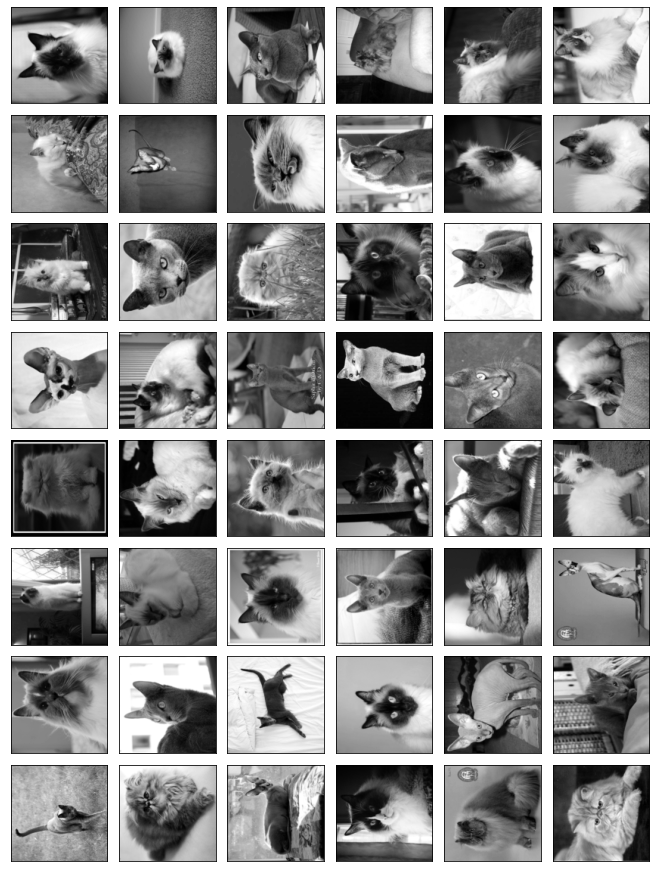


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the training segmentation labels]



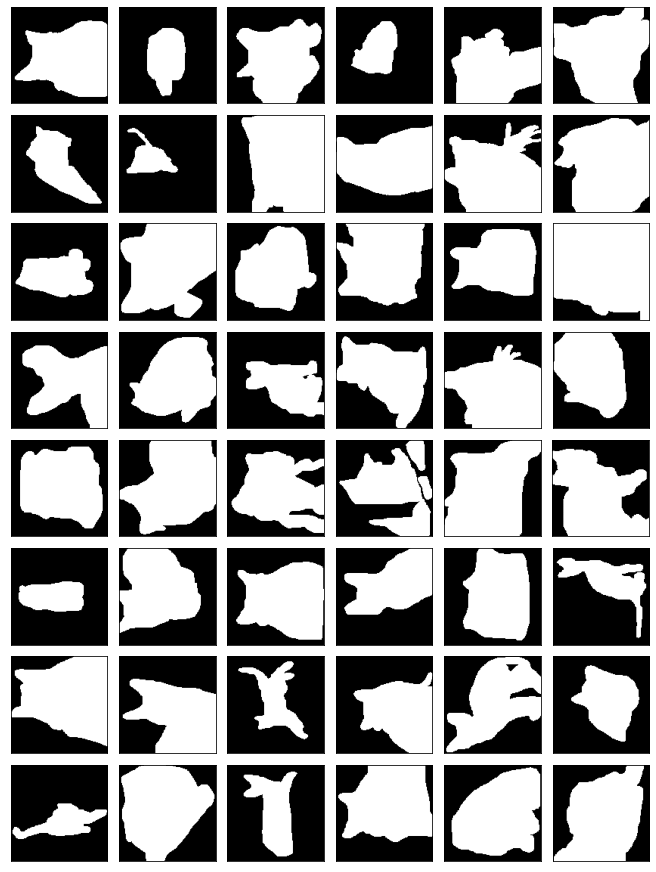


################################################################################
#
# RESULT # 03
#
################################################################################

[plot examples of the training segmentation results]



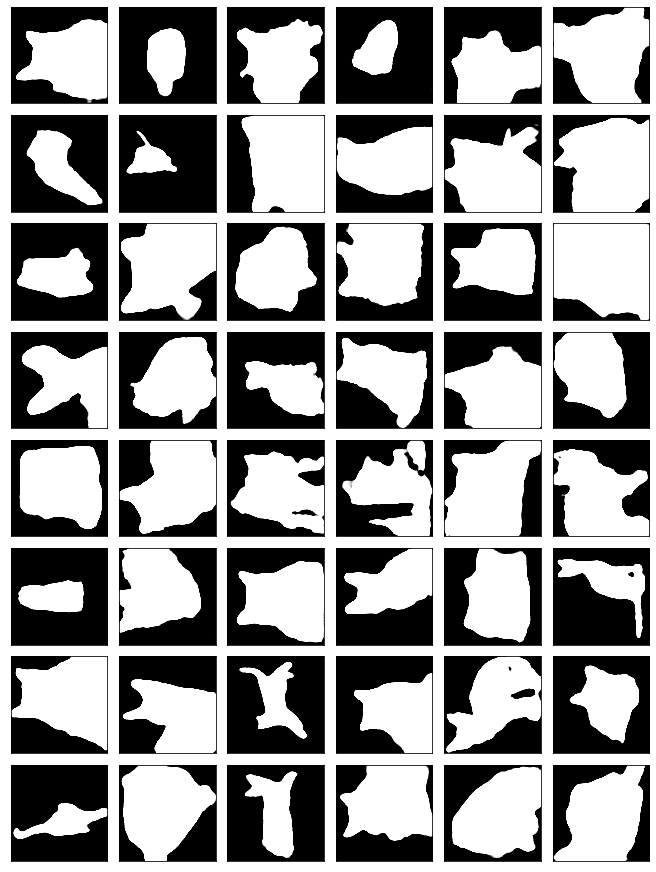


################################################################################
#
# RESULT # 04
#
################################################################################

[plot examples of the testing images]



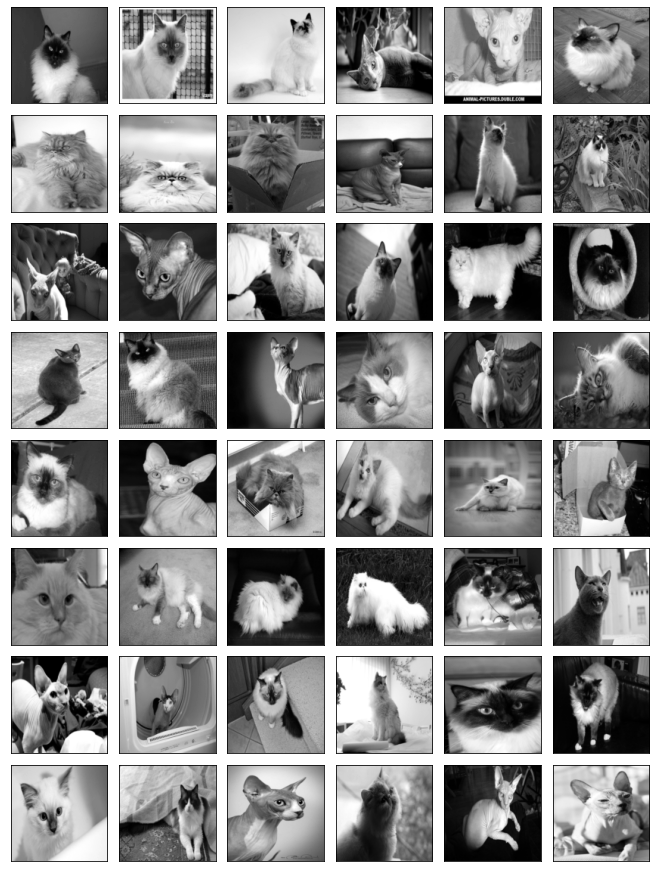


################################################################################
#
# RESULT # 05
#
################################################################################

[plot examples of the testing segmentation labels]



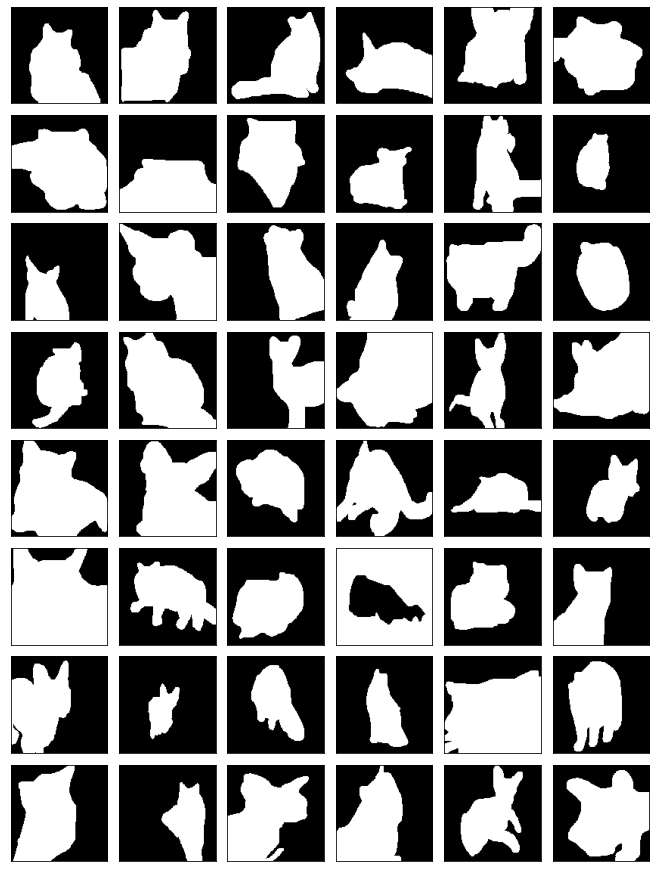


################################################################################
#
# RESULT # 06
#
################################################################################

[plot examples of the testing segmentation results]



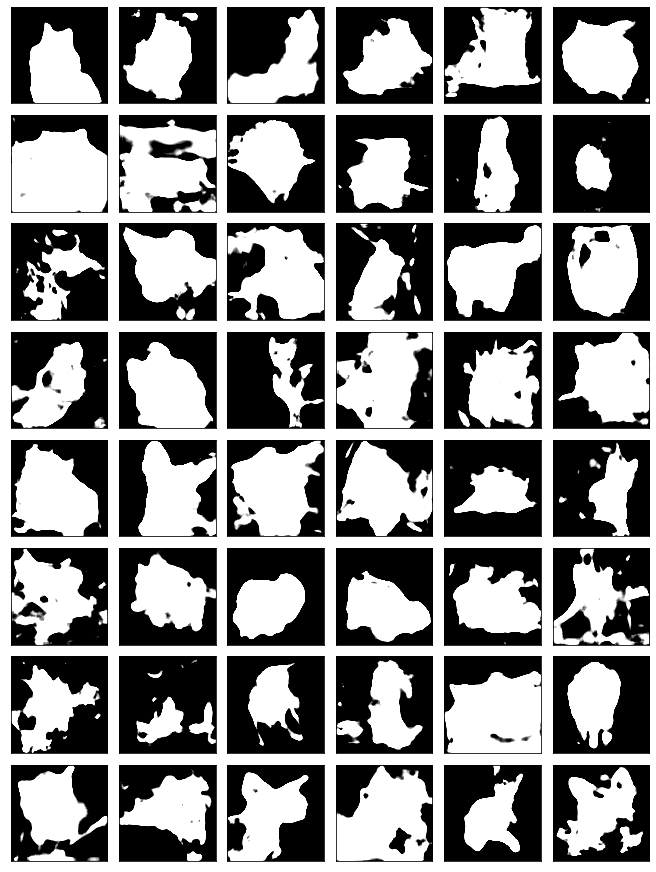


################################################################################
#
# RESULT # 07
#
################################################################################

[plot the training loss]



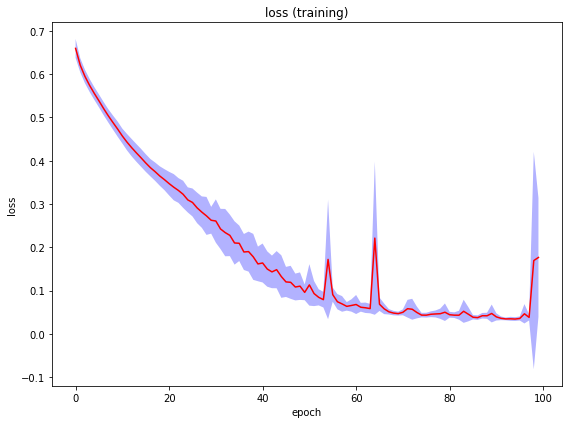


################################################################################
#
# RESULT # 08
#
################################################################################

[plot the training accuracy]



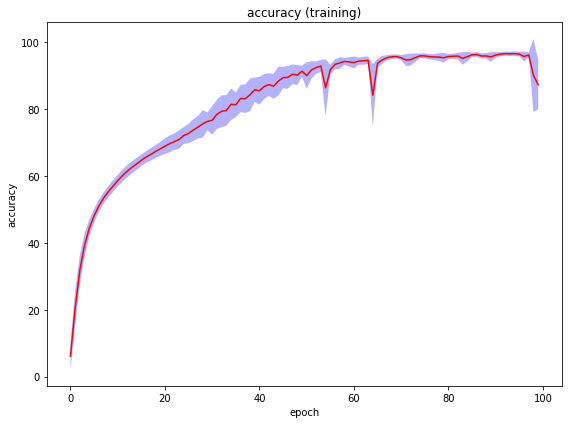


################################################################################
#
# RESULT # 09
#
################################################################################

[plot the testing loss]



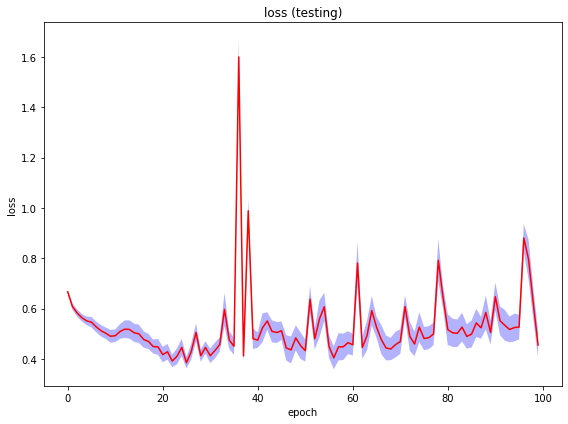


################################################################################
#
# RESULT # 10
#
################################################################################

[plot the testing accuracy]



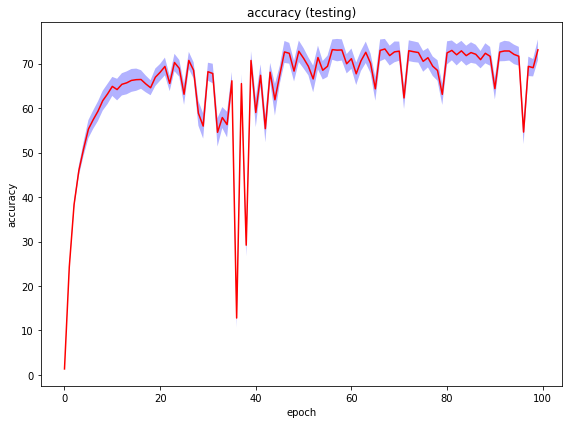


################################################################################
#
# RESULT # 11
#
################################################################################

[print the training loss at the last 10 epochs]

index =  0, value = 0.0391514695
index =  1, value = 0.0358529463
index =  2, value = 0.0344934205
index =  3, value = 0.0347581811
index =  4, value = 0.0341982752
index =  5, value = 0.0355158497
index =  6, value = 0.0463583773
index =  7, value = 0.0379816337
index =  8, value = 0.1693587518
index =  9, value = 0.1764780762

################################################################################
#
# RESULT # 12
#
################################################################################

[print the training accuracy at the last 10 epochs]

index =  0, value = 96.1874664998
index =  1, value = 96.4623416203
index =  2, value = 96.6085023260
index =  3, value = 96.5651165975
index =  4, value = 96.6329844166
index =  5, value = 96.4853350830


In [44]:
number_result = 16

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)